In [103]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline
import vivarium, vivarium.test_util as vtu
from vivarium.framework.event import listens_for
from vivarium.framework.population import uses_columns

In [265]:
n_simulants = 1500
n_days = 365
t_start = pd.Timestamp('2017-01-01')
t_timestep = 1

In [270]:
class HIVCohortFollowUp:
    def __init__(self):
        self.reports = {}
    
    @listens_for('initialize_simulants')
    @uses_columns(['state', 'next_appointment', 'first_visit','follow_up_duration'])
    def initialize(self, event):
        # create the population dataframe
        population = pd.DataFrame(index=event.index)
        population['state'] = 'Out' #Followed, LTFU, Dead,   
        population['next_appointment'] = pd.NaT
        population['follow_up_duration'] = 0
        
        # Give first visit
        first_visit = np.round(np.random.uniform(0, 365, n_simulants))
        population['first_visit'] = t_start + pd.to_timedelta(first_visit, 'D')
        
        # Give first follow up
        rows = np.random.binomial(1, 0.5, size=len(population))
        population['next_appointment'] = population['first_visit'] + pd.Timedelta(days=7*4)
        
        population.loc[population['first_visit'] == t_start , 'state'] = 'Followed'
        
        # update the population in the model
        event.population_view.update(population)
        
        
    @listens_for('time_step')
    @uses_columns(['state', 'first_visit'], 'state == "Out"')
    def new_patients(self, event):
        df = event.population
        df.loc[df['first_visit'] == event.time, 'state'] = 'Followed'
        
        event.population_view.update(df)
        
    @listens_for('time_step')
    @uses_columns(['state', 'next_appointment'], 'state != "Out"')
    def next_appointment(self, event):
        df = event.population
        df.visit_delay = (event.time - df['next_appointment'])/ np.timedelta64(1, 'D')
        
        
        # For now : probability of patient coming to visit only depends on wether he is late or early
        # IF early : p = .05 , IF late : p = .8, IF on day of : p = 0.95
        early = df[df.visit_delay < 0]
        visit = np.random.binomial(1, 0.001, size=len(early))
        visitors = list(early.index[visit == 1])
        
        on_time =  df[df.visit_delay == 0]
        visit = np.random.binomial(1, 0.8, size=len(on_time))
        visitors = visitors + list(on_time.index[visit == 1])
        
        late = df[df.visit_delay > 0]
        visit = np.random.binomial(1, 0.001, size=len(late))
        visitors = visitors + list(late.index[visit == 1])
        
        
        
        df.loc[visitors, 'next_appointment'] = event.time + pd.Timedelta(days=7*4)
        
        df.visit_delay = (event.time - df['next_appointment'])/ np.timedelta64(1, 'D')
        df.loc[df.visit_delay > 90 , 'state'] = 'LTFU'
        df.loc[df.visit_delay <= 90 , 'state'] = 'Followed'
        
        event.population_view.update(df)
        
    @listens_for('time_step')
    @uses_columns(['state'], 'state != "Out"')
    def export_report_datapoint(self, event):
        date = event.time
        self.reports[date] = event.population.state.value_counts()

In [271]:
components = [HIVCohortFollowUp()]
vtu.config.simulation_parameters.time_step = 1/365
simulation = vtu.setup_simulation(components, population_size=n_simulants, start=t_start)
vtu.pump_simulation(simulation, time_step_days=t_timestep, duration=pd.Timedelta(days=n_days))
print(simulation.population.population.state.value_counts())
print(simulation.population.population.state.value_counts() / len(simulation.population.population))

Followed    1002
LTFU         498
Name: state, dtype: int64
Followed    0.668
LTFU        0.332
Name: state, dtype: float64


In [272]:
report_out = pd.DataFrame.from_dict(components[0].reports , orient='index')

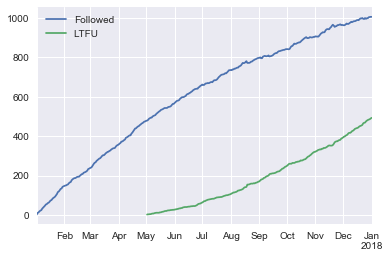

In [273]:
report_out.plot()